In [7]:
from PIL import Image
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pylab import draw_networkx_edges
from networkx.classes.function import get_node_attributes

drive.mount('/content/drive')
occupancy_map_img = Image.open('drive/MyDrive/occupancy_map.png')
occupancy_grid = (np.asarray(occupancy_map_img) > 0).astype(int)
Node_Num = 1
G = nx.Graph()
G.clear()
M = len(occupancy_grid)
N = len(occupancy_grid[0])

def heuristic(v1,v2):   # euclidean distance
    x1,y1 = v1
    x2,y2 = v2
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)


def PathExists(v1,v2):
    x1,y1 = v1; x2,y2 = v2
    d0 = abs(x2-x1); d1 = abs(y2-y1)
    possible = []
    if d0 > d1:
        possible = (np.c_[np.linspace(x1, x2, d0+1, dtype=np.int32),np.round(np.linspace(y1, y2, d0+1)).astype(np.int32)]).tolist()
    else:
        possible = (np.c_[np.round(np.linspace(x1, x2, d1+1)).astype(np.int32),np.linspace(y1, y2, d1+1, dtype=np.int32)]).tolist()

    for i in possible:
        if occupancy_grid[i[1],i[0]] == 0:
            return False
    return True

def getMapDistribution(mode):
    if mode == 1:
        p_x = [0]*M # free space distribution across x
        p_y = [0]*N # free spcae distribution across y
        totalfree = 0
        for i in range(M):
            for j in range(N):
                if occupancy_grid[i,j] == 1:
                    p_x[i] += 1
                    p_y[j] += 1
                    totalfree +=1
        
        p_x[:] = [x / totalfree for x in p_x]
        p_y[:] = [y / totalfree for y in p_y]
        return p_x,p_y
    elif mode == 0:
        p_x = [1/M]*M
        p_y = [1/N]*N
        return p_x,p_y


def FreeSpace(p_x,p_y):    
    while True:
        x_rand = np.random.choice(M,1,p=p_x)
        y_rand = np.random.choice(N,1,p=p_y)

        if occupancy_grid[x_rand,y_rand] == 1:
            return x_rand[0],y_rand[0]


def AddVertex(G,x,y,d_max):
    global Node_Num
    G.add_node(Node_Num, pos = (y,x))
    Node_Num += 1

    for i in range(1,Node_Num):
        d = heuristic(G.nodes[i]['pos'],(y,x))
        if G.nodes[i]['pos'] != (y,x) and d <= d_max:
            if PathExists(G.nodes[i]['pos'], (y,x)):
                G.add_edge(i,Node_Num-1, weight = d)


def ConstructPRM(N,d_max):
    global G
    p_x,p_y = getMapDistribution(0) # 0 for Uniform, 1 for more samples from dense free space
    for i in range(N):
        x,y = FreeSpace(p_x,p_y)
        AddVertex(G,x,y,d_max)
    
    return G

def main():
    global Node_Num
    global G
    Node_Num = 1
    G = ConstructPRM(2500,75)

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[2501, 1928, 1300, 2114, 2219, 1466, 1162, 657, 1494, 703, 738, 2416, 1423, 2404, 931, 1653, 2459, 1280, 2502]


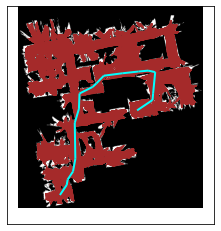

In [16]:
s = (635,140)
g = (350,400)
node_s = -1
node_g = -1
for i in range(1,Node_Num):
        if G.nodes[i]['pos'] == (s[1],s[0]):
            node_s = i
        if G.nodes[i]['pos'] == (g[1],g[0]):
            node_g = i

if node_s == -1:
    AddVertex(G,s[0],s[1],75)
    node_s = Node_Num - 1

if node_g == -1:
    AddVertex(G,g[0],g[1],75)
    node_g = Node_Num - 1

goal_path = nx.astar_path(G,node_s,node_g)
print(goal_path)
edge = []
for i in range(len(goal_path)-1):
    edge.append((goal_path[i],goal_path[i+1]))
plt.imshow(occupancy_map_img, cmap='gray')
draw_networkx_edges(G,get_node_attributes(G,'pos'),edge_color='brown')

draw_networkx_edges(G,get_node_attributes(G,'pos'),edgelist=edge,edge_color= 'cyan',width =2)

In [ ]:
G.nodes()